**Note that the code in this notebook might not be as readable or documented. It's meant to compute/visualize certain statistics/measures that can be used globally for the entire dataset.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

%matplotlib inline

from capstone.utils import miccai, visualize
from capstone.paths import DEFAULT_DATA_STORAGE

In [2]:
root_dir = DEFAULT_DATA_STORAGE + "/miccai/train/"
patient_collection = miccai.PatientCollection(root_dir)

sample = DEFAULT_DATA_STORAGE + "/miccai/train/0522c0017/"
sample_patient = miccai.Patient(sample)

In [3]:
def structure_boundary_coordinates(patient):
    min_x_list = []
    max_x_list = []
    min_y_list = []
    max_y_list = []
    min_z_list = []
    max_z_list = []

    for structure in miccai.STRUCTURES:
        region_vol = patient.structures[structure]
        if region_vol is not None:
            structure_indicator_along_x = region_vol.as_numpy()[0].max(axis=(0, 2))
            structure_indicator_along_y = region_vol.as_numpy()[0].max(axis=(0, 1))
            structure_indicator_along_z = region_vol.as_numpy()[0].max(axis=(1, 2))

            min_x_list.append(np.where(structure_indicator_along_x == 1)[0].min())
            max_x_list.append(np.where(structure_indicator_along_x == 1)[0].max())
            min_y_list.append(np.where(structure_indicator_along_y == 1)[0].min())
            max_y_list.append(np.where(structure_indicator_along_y == 1)[0].max())
            min_z_list.append(np.where(structure_indicator_along_z == 1)[0].min())
            max_z_list.append(np.where(structure_indicator_along_z == 1)[0].max())

    min_x = np.min(min_x_list)
    max_x = np.max(max_x_list)
    min_y = np.min(min_y_list)
    max_y = np.max(max_y_list)
    min_z = np.min(min_z_list) / patient.num_slides
    max_z = np.max(max_z_list) / patient.num_slides
    
    return [min_x, max_x, min_y, max_y, min_z, max_z]

results = patient_collection.apply_function(structure_boundary_coordinates)
results

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:28<00:00,  3.55s/it]


{'0522c0001': [206, 316, 147, 254, 0.4766355140186916, 0.822429906542056],
 '0522c0002': [190, 327, 107, 231, 0.4307692307692308, 0.7538461538461538],
 '0522c0003': [197, 318, 164, 273, 0.4552238805970149, 0.7761194029850746],
 '0522c0009': [187, 323, 141, 265, 0.4861111111111111, 0.7847222222222222],
 '0522c0013': [189, 319, 139, 264, 0.4927536231884058, 0.8043478260869565],
 '0522c0017': [190, 321, 118, 229, 0.4230769230769231, 0.75],
 '0522c0070': [187, 324, 146, 266, 0.4140625, 0.7578125],
 '0522c0077': [181, 333, 144, 269, 0.3923076923076923, 0.7538461538461538],
 '0522c0081': [168, 339, 126, 265, 0.43125, 0.7875],
 '0522c0125': [179, 343, 98, 264, 0.4605263157894737, 0.9736842105263158],
 '0522c0132': [187, 312, 152, 270, 0.40869565217391307, 0.7652173913043478],
 '0522c0147': [170, 367, 107, 311, 0.3897058823529412, 0.75],
 '0522c0149': [161, 344, 149, 288, 0.3953488372093023, 0.7209302325581395],
 '0522c0161': [181, 341, 127, 250, 0.39705882352941174, 0.7132352941176471],
 '052

In [4]:
coordinates = np.array(list(results.values()))

min_ = coordinates.min(axis=0)
min_x, min_y, min_z = min_[0], min_[2], min_[4]

max_ = coordinates.max(axis=0)
max_x, max_y, max_z = max_[1], max_[3], max_[5]

print(f"Height : {min_x, max_x}")  #120, 400
print(f"Width: {min_y, max_y}")  # 55, 335
print(f"Depth: {min_z, max_z}")  # 0.32, 0.99

Height : (161.0, 367.0)
Width: (96.0, 311.0)
Depth: (0.3897058823529412, 0.9736842105263158)


In [5]:
def get_region_voxels(patient):
    voxel_dict = {}
    for structure in miccai.STRUCTURES:
        region_volume = patient.structures[structure]
        if region_volume is not None:
            voxel_dict[structure] = patient.image.as_numpy()[
                region_volume.as_numpy() == 1
            ]
        else:
            voxel_dict[structure] = None
            
    return voxel_dict

results = patient_collection.apply_function(get_region_voxels)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:24<00:00,  3.38s/it]


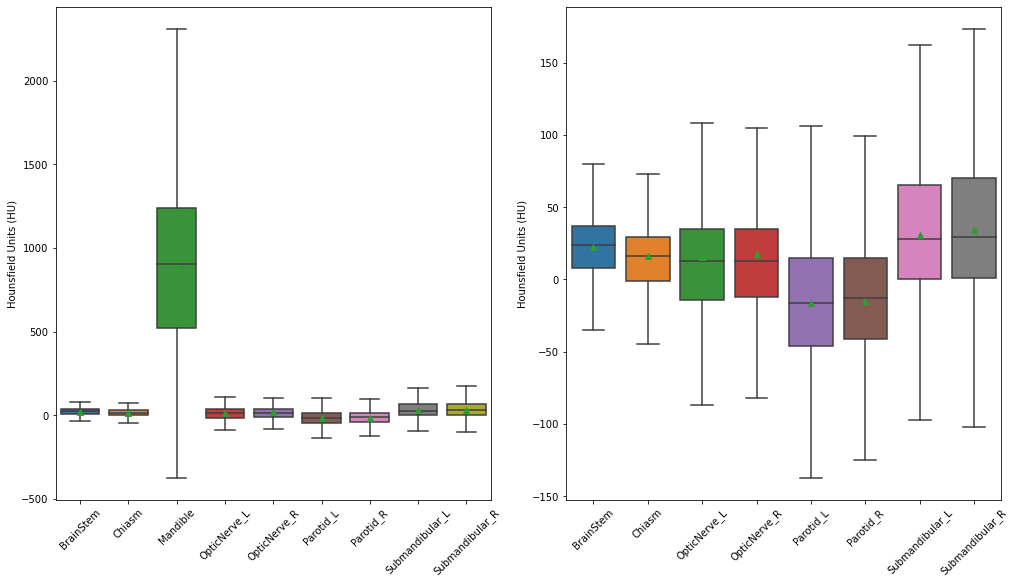

In [6]:
region_voxels = {structure: [] for structure in miccai.STRUCTURES}

for structure in region_voxels.keys():
    for (p_name, p_voxel) in results.items():
        if p_voxel[structure] is not None:
            region_voxels[structure].append(p_voxel[structure])
            
region_voxels = {
    structure: np.concatenate(voxel_list)
    for (structure, voxel_list) in region_voxels.items()
}

fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(14, 8))
sns.boxplot(data=list(region_voxels.values()), showmeans=True, showfliers=False, ax=axes[0])
axes[0].set_xticklabels(region_voxels.keys(), rotation=45);
axes[0].set_ylabel("Hounsfield Units (HU)");

_ = region_voxels.pop("Mandible")

sns.boxplot(data=list(region_voxels.values()), showmeans=True, showfliers=False, ax=axes[1])
axes[1].set_xticklabels(region_voxels.keys(), rotation=45);
axes[1].set_ylabel("Hounsfield Units (HU)");

In [7]:
def structure_annotations(patient):
    indicator = []
    for structure in miccai.STRUCTURES:
        temp = 1 if patient.structures[structure] is not None else 0
        indicator.append(temp)
        
    return indicator

results = patient_collection.apply_function(structure_annotations)

print(f"Each patient has minimum {np.array(list(results.values())).sum(axis=1).min()} structures annotated.")
print("Given below is the number of annotations available for each structure:\n")
for structure, count in zip(miccai.STRUCTURES, np.array(list(results.values())).sum(axis=0)):
    print(structure, count)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:04<00:00,  2.59s/it]

Each patient has minimum 6 structures annotated.
Given below is the number of annotations available for each structure:

BrainStem 25
Chiasm 25
Mandible 20
OpticNerve_L 25
OpticNerve_R 25
Parotid_L 25
Parotid_R 25
Submandibular_L 20
Submandibular_R 18


In [8]:
def voxel_count(patient, crop=False):
    temp_patient = patient
    if crop:
        temp_patient.crop_data()
    foreground_voxels = 0
    structure_voxels = []
    for structure in miccai.STRUCTURES:
        region_volume = temp_patient.structures[structure]
        if region_volume is not None:
            region_voxels = (region_volume.as_numpy() == 1).sum()
            foreground_voxels += region_voxels
            structure_voxels.append(region_voxels)
        else:
            structure_voxels.append(0)
            
    foreground_ratio = foreground_voxels / np.prod(temp_patient.image.as_numpy().shape)
    structure_ratio = np.array(structure_voxels) / foreground_voxels
            
    return foreground_ratio, structure_ratio

results = patient_collection.apply_function(voxel_count)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:17<00:00,  3.11s/it]


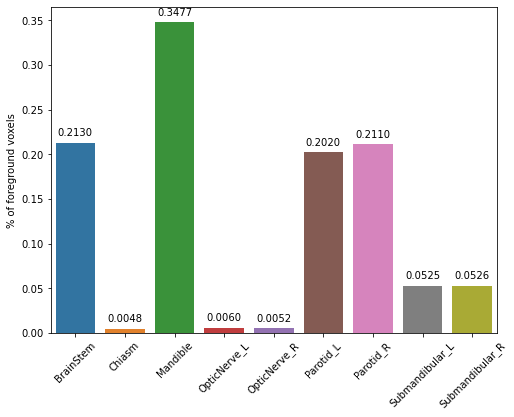

In [9]:
foreground_ratios = []
structure_ratios = []

for (f, s) in results.values():
    foreground_ratios.append(f)
    structure_ratios.append(s)
    
structure_ratios = np.array(structure_ratios)
foreground_ratios = np.array(foreground_ratios)
temp = (structure_ratios != 0).sum(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bar = sns.barplot(x=miccai.STRUCTURES, y=structure_ratios.sum(axis=0) / temp, orient="v", ax=ax)
for p in bar.patches:
    bar.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 10), textcoords='offset points'
    )
ax.set_xticklabels(miccai.STRUCTURES, rotation=45)
ax.set_ylabel("% of foreground voxels")
plt.show()